In [1]:
# https://www.kaggle.com/dlarionov/feature-engineering-xgboost

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle



In [3]:
sys.executable, sys.version,sys.version_info

('/home/ankish/anaconda3/bin/python',
 '3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 17:14:51) \n[GCC 7.2.0]',
 sys.version_info(major=3, minor=6, micro=6, releaselevel='final', serial=0))

In [4]:
import os
os.listdir()

['tfvectorizer.ipynb',
 '.ipynb_checkpoints',
 'test.csv',
 'items.csv',
 'future sale prediction.ipynb',
 'all.zip',
 'test.csv.gz',
 'Untitled.ipynb',
 'sample_submission.csv.gz',
 'sales_train.csv.gz',
 'item_categories.csv',
 'sales_train_v2.csv',
 'shops.csv']

In [5]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train_v2.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('test.csv').set_index('ID')

## Remove Outlier

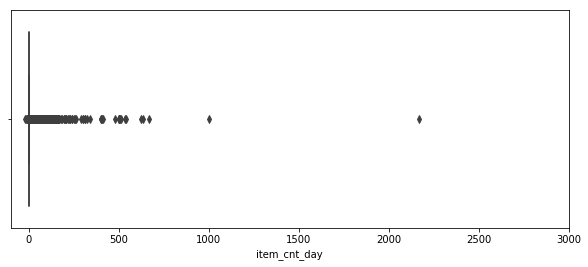

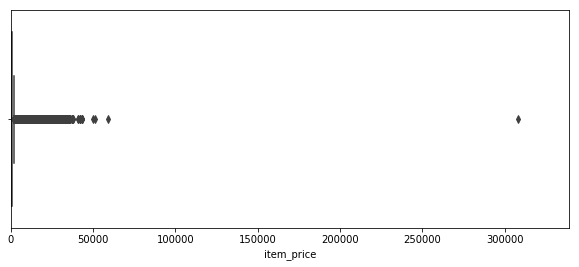

In [6]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)



In [7]:


train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]



In [8]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price < 0, 'item_price'] = median

In [9]:
train[train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [10]:
train.iloc[1:4]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0


# Several shops are duplicates of each other (according to its name)


In [1]:
'''
shops['shop_name'][[1,57,1,58,10,11]]

1     !Якутск ТЦ "Центральный" фран
57          Якутск Орджоникидзе, 56
1     !Якутск ТЦ "Центральный" фран
58          Якутск ТЦ "Центральный"
10       Жуковский ул. Чкалова 39м?
11       Жуковский ул. Чкалова 39м²
'''

'\nshops[\'shop_name\'][[1,57,1,58,10,11]]\n\n1     !Якутск ТЦ "Центральный" фран\n57          Якутск Орджоникидзе, 56\n1     !Якутск ТЦ "Центральный" фран\n58          Якутск ТЦ "Центральный"\n10       Жуковский ул. Чкалова 39м?\n11       Жуковский ул. Чкалова 39м²\n'

In [11]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11


In [12]:
test.shop_id.unique()

array([ 5,  4,  6,  3,  2,  7, 11, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45])

In [13]:
shops.shop_name.unique().shape,shops.shop_name.shape

((60,), (60,))

In [14]:
shops.shop_name[:5]

0     !Якутск Орджоникидзе, 56 фран
1     !Якутск ТЦ "Центральный" фран
2                  Адыгея ТЦ "Мега"
3    Балашиха ТРК "Октябрь-Киномир"
4          Волжский ТЦ "Волга Молл"
Name: shop_name, dtype: object

In [15]:
shops.shop_name.str.split(' ')[:5]

0    [!Якутск, Орджоникидзе,, 56, фран]
1    [!Якутск, ТЦ, "Центральный", фран]
2                  [Адыгея, ТЦ, "Мега"]
3    [Балашиха, ТРК, "Октябрь-Киномир"]
4         [Волжский, ТЦ, "Волга, Молл"]
Name: shop_name, dtype: object

In [16]:
shops.shop_name.str.split(' ').map(lambda x: x[0])[:5]

0     !Якутск
1     !Якутск
2      Адыгея
3    Балашиха
4    Волжский
Name: shop_name, dtype: object

In [17]:
num = shops.shop_name.str.split(' ').map(lambda x: x[0]).unique().shape[0]
print('{} out of 60 are uniques '.format(num))
shops.shop_name.str.split(' ').map(lambda x: x[0]).unique()

32 out of 60 are uniques 


array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

# shops preprocessing
### first name in shop_name is city name

In [18]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [19]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [20]:
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


# item_category preprocessing
### each cat contains type and subtype

In [21]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [22]:
'''
.strip() 
    removes all whitespace at the start and end, including spaces, 
    tabs, newlines and carriage returns. Leaving it in doesn't do 
    any harm, and allows your program to deal with unexpected extra 
    whitespace inserted into the file.
'''

"\n.strip() \n    removes all whitespace at the start and end, including spaces, \n    tabs, newlines and carriage returns. Leaving it in doesn't do \n    any harm, and allows your program to deal with unexpected extra \n    whitespace inserted into the file.\n"

In [23]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]


In [24]:
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [26]:
# cats['item_category_name'][:15]#.str.split('-')

In [73]:
cats['item_category_name'].str.split('-')[:5]

0    [PC ,  Гарнитуры/Наушники]
1           [Аксессуары ,  PS2]
2           [Аксессуары ,  PS3]
3           [Аксессуары ,  PS4]
4           [Аксессуары ,  PSP]
Name: item_category_name, dtype: object

# Items preprocessing

In [27]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [28]:
items.drop(['item_name'], axis=1, inplace=True)

In [29]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)


(363, 5100, 214200)

In [30]:
'''train set contains only pairs which were sold or returned in the past'''

'train set contains only pairs which were sold or returned in the past'

In [35]:
temp = train[train.date_block_num == 1]
temp.shop_id.unique(),temp.item_id.unique()

(array([50, 47, 51, 52, 42, 46, 43, 54, 56, 59,  7, 53, 16, 18, 19, 14, 15,
        13, 23, 24, 21, 25, 22,  4,  3,  5, 58,  2,  6, 57,  8, 12, 11, 31,
        32, 35, 44, 41, 45, 37, 38, 26, 27, 29, 30, 28]),
 array([ 3880,  4128,  4124, ..., 12885, 12791, 13433]))

In [40]:
temp.shop_id.value_counts().shape, temp.shop_id.value_counts()

((46,), 31    8735
 25    6471
 54    6359
 57    5064
 28    4352
 27    3769
 6     3329
 42    3251
 58    2984
 18    2739
 50    2640
 19    2482
 30    2431
 56    2411
 29    2384
 15    2348
 46    2308
 16    2306
 7     2240
 26    2237
 51    1990
 37    1989
 35    1926
 22    1857
 4     1815
 23    1748
 53    1722
 21    1711
 59    1696
 44    1665
 41    1661
 43    1659
 47    1652
 24    1600
 14    1548
 52    1513
 38    1422
 32    1378
 45    1378
 8     1092
 13     925
 11     912
 12     854
 5      845
 3      761
 2      454
 Name: shop_id, dtype: int64)

In [41]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    

In [47]:
len(matrix), matrix[0].shape

(34, (365175, 3))

##  np.vstack(([1,2,3],[4,5,6]))
## array([[1, 2, 3],
##           [4, 5, 6]])


In [51]:
np.vstack([matrix[0],matrix[1]])

array([[    0,    59, 22154],
       [    0,    59,  2552],
       [    0,    59,  2554],
       ...,
       [    1,    28, 12885],
       [    1,    28, 12791],
       [    1,    28, 13433]], dtype=int16)

In [52]:
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)


In [54]:
matrix.head(20)

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
5,0,59,2565
6,0,59,2572
7,0,59,2573
8,0,59,2574
9,0,59,2593


In [55]:
matrix.sort_values(cols,inplace=True)
time.time() - ts

403.80899238586426

In [57]:
matrix.head(10)

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32
114603,0,2,33
114604,0,2,34
114902,0,2,35
118327,0,2,40
117720,0,2,41


In [58]:
train.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [62]:
# temp = train[train.date_block_num == 1]
del temp

In [200]:
# temp
# '''
#  	date 	date_block_num 	shop_id 	item_id 	item_price 	item_cnt_day
#     115690 	21.02.2013 	1 	50 	3880 	1499.000000 	1.0
#     115691 	14.02.2013 	1 	50 	3880 	1499.000000 	1.0
#     115692 	21.02.2013 	1 	50 	4128 	899.000000 	1.0
#     115693 	13.02.2013 	1 	50 	4124 	249.000000 	1.0
#     115694 	24.02.2013 	1 	50 	3880 	1499.000000 	1.0
#     115695 	07.02.2013 	1 	50 	3880 	1499.000000 	1.0
# '''

In [63]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [64]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [66]:
a = train.item_cnt_day.unique()

In [69]:
[x for x in a if x<0]

[-1.0, -5.0, -6.0, -3.0, -2.0, -4.0, -22.0, -16.0, -9.0]

In [72]:
train.item_cnt_day.head(), train.item_price.head()

(0    1.0
 1    1.0
 2   -1.0
 3    1.0
 4    1.0
 Name: item_cnt_day, dtype: float64, 0     999.00
 1     899.00
 2     899.00
 3    1709.05
 4    1099.00
 Name: item_price, dtype: float64)

In [73]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']


In [74]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [199]:
# train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})


In [76]:
train.groupby(['date_block_num']).agg({'item_cnt_day':['sum']})

,item_cnt_day
,sum
date_block_num,
0,131479.0
1,128090.0
2,147142.0
3,107190.0
4,106970.0
5,125381.0
6,116966.0
7,125291.0


In [77]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})


In [78]:
group.columns

MultiIndex(levels=[['item_cnt_day'], ['sum']],
           labels=[[0], [0]])

In [79]:
group.columns = ['item_cnt_month']


In [80]:
group.columns

Index(['item_cnt_month'], dtype='object')

In [81]:
group.head()

item_cnt_month
date_block_num shop_id item_id                
0              2       27                  1.0
                       33                  1.0
                       317                 1.0
                       438                 1.0
                       471                 2.0

In [82]:
group.reset_index(inplace=True)

In [83]:
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [ ]:

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts



In [84]:
matrix.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


In [85]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [86]:
matrix = pd.merge(matrix, group, on=cols, how='left')

In [90]:
matrix.item_cnt_month.isnull().sum()

9304681

In [91]:
matrix.shape

(10913804, 4)

In [92]:
10913804 - 9304681

1609123

In [93]:
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts



495.77037525177

In [94]:
train.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [95]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)


In [100]:
matrix.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [101]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.05324721336364746

In [102]:
matrix.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [198]:
# matrix[matrix.date_block_num == 33]
'''
 	date_block_num 	shop_id 	item_id 	item_cnt_month
10675632 	33 	2 	30 	0.0
10675633 	33 	2 	31 	1.0
10675634 	33 	2 	32 	0.0
10675635 	33 	2 	33 	0.0
10675636 	33 	2 	40 	0.0
'''

'\n \tdate_block_num \tshop_id \titem_id \titem_cnt_month\n10675632 \t33 \t2 \t30 \t0.0\n10675633 \t33 \t2 \t31 \t1.0\n10675634 \t33 \t2 \t32 \t0.0\n10675635 \t33 \t2 \t33 \t0.0\n10675636 \t33 \t2 \t40 \t0.0\n'

In [197]:
matrix[matrix.date_block_num == 34].head()

NameError: name 'matrix' is not defined

## Shops/Items/Cats features

In [105]:
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [106]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [107]:
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [108]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')


In [109]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4


In [110]:
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts


23.024987936019897

## Target lag Features

In [111]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df


In [112]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts


25.780369520187378

## Mean encoding features

In [113]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

7.8178870677948

In [115]:
group.head()

,date_block_num,date_avg_item_cnt
0,0,0.347168
1,1,0.324463
2,2,0.355469
3,3,0.275391
4,4,0.265137


In [116]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
for col in matrix.columns:
    print(col)

date_block_num
shop_id
item_id
item_cnt_month
city_code
item_category_id
type_code
subtype_code
item_cnt_month_lag_1
item_cnt_month_lag_2
item_cnt_month_lag_3
item_cnt_month_lag_6
item_cnt_month_lag_12
date_avg_item_cnt_lag_1


In [123]:
train.columns,shops.columns,cats.columns,items.columns

(Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
        'item_cnt_day', 'revenue'],
       dtype='object'),
 Index(['shop_id', 'city_code'], dtype='object'),
 Index(['item_category_id', 'type_code', 'subtype_code'], dtype='object'),
 Index(['item_id', 'item_category_id'], dtype='object'))

In [124]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


30.82472252845764

In [125]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


31.46481227874756

In [128]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


10.311087846755981

In [129]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

11.607962369918823

In [130]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

11.299512147903442

In [2]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

NameError: name 'time' is not defined

In [132]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts



10.962101936340332

In [133]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


16.185481548309326

In [134]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


11.128100633621216

In [135]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


11.282824277877808

In [138]:
for i in matrix.columns:
    print(i)

date_block_num
shop_id
item_id
item_cnt_month
city_code
item_category_id
type_code
subtype_code
item_cnt_month_lag_1
item_cnt_month_lag_2
item_cnt_month_lag_3
item_cnt_month_lag_6
item_cnt_month_lag_12
date_avg_item_cnt_lag_1
date_item_avg_item_cnt_lag_1
date_item_avg_item_cnt_lag_2
date_item_avg_item_cnt_lag_3
date_item_avg_item_cnt_lag_6
date_item_avg_item_cnt_lag_12
date_shop_avg_item_cnt_lag_1
date_shop_avg_item_cnt_lag_2
date_shop_avg_item_cnt_lag_3
date_shop_avg_item_cnt_lag_6
date_shop_avg_item_cnt_lag_12
date_cat_avg_item_cnt_lag_1
date_shop_cat_avg_item_cnt_lag_1
date_shop_type_avg_item_cnt_lag_1
date_shop_subtype_avg_item_cnt_lag_1
date_city_avg_item_cnt_lag_1
date_item_city_avg_item_cnt_lag_1
date_type_avg_item_cnt_lag_1
date_subtype_avg_item_cnt_lag_1


In [139]:
matrix.columns.shape

(32,)

## Trend Feature

In [140]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

time.time()-ts

4.049905300140381

In [141]:
ts = time.time()
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

time.time() - ts

3.0533320903778076

In [142]:
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')


In [143]:
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']


In [144]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0


In [145]:
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)


In [196]:
# for i in matrix.columns:
#     print(i)

In [152]:
matrix.delta_price_lag_1.isnull().value_counts()

False    8629143
True     2498861
Name: delta_price_lag_1, dtype: int64

In [153]:
ts = time.time()
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts


1.3454554080963135

In [195]:
# for i in matrix.columns:
#     print(i)

In [155]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

16.41594433784485

In [156]:
matrix['month'] = matrix['date_block_num'] % 12


In [157]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)


In [159]:
matrix.describe()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days
count,1.112800e+07,1.112800e+07,1.112800e+07,11128004.0,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,8629143.0,7989211.0,7379083.0,5742261.0,3139542.0,8.629143e+06,8.629143e+06,7.989211e+06,7.379083e+06,5.742261e+06,3.139542e+06,8.629143e+06,7.989211e+06,7.379083e+06,5.742261e+06,3.139542e+06,8.629143e+06,8.629143e+06,8.629143e+06,8.629143e+06,8.629143e+06,8.629143e+06,8.629143e+06,8.629143e+06,1.112800e+07,8.629143e+06,1.112800e+07,1.112800e+07
mean,1.533960e+01,3.138372e+01,1.130371e+04,NaN,1.530356e+01,4.494398e+01,1.107023e+01,1.810709e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.268710e+00,3.040316e+01
std,9.760412e+00,1.730666e+01,6.210934e+03,0.0,8.018806e+00,1.514000e+01,2.854886e+00,2.015452e+01,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.418476e+00,8.795099e-01
min,0.000000e+00,2.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,2.430420e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.025532e-04,3.025532e-04,3.025532e-04,0.000000e+00,3.025532e-04,1.550293e-02,0.000000e+00,0.000000e+00,0.000000e+00,1.963806e-02,0.000000e+00,2.040100e-02,1.785278e-02,-1.000000e+00,-9.995117e-01,0.000000e+00,2.800000e+01
25%,7.000000e+00,1.600000e+01,5.947000e+03,0.0,1.000000e+01,3.700000e+01,1.100000e+01,2.000000e+00,0.0,0.0,0.0,0.0,0.0,2.722168e-01,4.650879e-02,5.999756e-02,6.121826e-02,6.524658e-02,8.001709e-02,1.737061e-01,1.752930e-01,1.756592e-01,1.773682e-01,1.812744e-01,1.702881e-01,6.878662e-02,9.991455e-02,7.019043e-02,1.759033e-01,0.000000e+00,1.802979e-01,1.691895e-01,-2.157593e-02,-2.459717e-01,2.000000e+00,3.000000e+01
50%,1.500000e+01,3.100000e+01,1.138800e+04,0.0,1.300000e+01,4.000000e+01,1.100000e+01,4.000000e+00,0.0,0.0,0.0,0.0,0.0,2.880859e-01,1.276855e-01,1.304932e-01,1.346436e-01,1.522217e-01,1.800537e-01,2.346191e-01,2.366943e-01,2.374268e-01,2.385254e-01,2.434082e-01,2.243652e-01,1.611328e-01,1.727295e-01,1.616211e-01,2.585449e-01,0.000000e+00,2.166748e-01,2.235107e-01,0.000000e+00,-6.970215e-02,5.000000e+00,3.100000e+01
75%,2.300000e+01,4.700000e+01,1.659200e+04,0.0,2.200000e+01,5.500000e+01,1.300000e+01,3.200000e+01,0.0,0.0,0.0,0.0,0.0,3.112793e-01,3.044434e-01,3.190918e-01,3.264160e-01,3.674316e-01,4.167480e-01,3.215332e-01,3.251953e-01,3.271484e-01,3.322754e-01,3.381348e-01,2.871094e-01,3.374023e-01,3.664551e-01,3.410645e-01,4.067383e-01,3.000488e-01,2.907715e-01,2.871094e-01,2.946472e-02,1.396484e-01,8.000000e+00,3.100000e+01
max,3.400000e+01,5.900000e+01,2.216900e+04,20.0,3.000000e+01,8.300000e+01,1.900000e+01,6.400000e+01,20.0,20.0,20.0,20.0,20.0,4.440918e-01,1.956250e+01,1.956250e+01,1.956250e+01,1.956250e+01,1.956250e+01,1.798828e+00,1.798828e+00,1.798828e+00,1.798828e+00,1.527344e+00,1.923438e+01,2.000000e+01,2.000000e+01,2.000000e+01,1.038086e+00,2.000000e+01,1.729688e+01,1.923438e+01,1.131250e+01,4.203125e+0

In [160]:
matrix.index

Int64Index([       0,        1,        2,        3,        4,        5,
                   6,        7,        8,        9,
            ...
            11127994, 11127995, 11127996, 11127997, 11127998, 11127999,
            11128000, 11128001, 11128002, 11128003],
           dtype='int64', length=11128004)

In [161]:
matrix.to_csv('future_prediction_features.csv',encoding='utf-8',index=False)
# df.to_csv(file_name, encoding='utf-8', index=False)

## Skipped some step
##### 'month', 'days', 'item_shop_last_sale','item_last_sale', 'item_shop_first_sale', 'item_first_sale']

In [162]:
matrix.drop(['month','days'],axis=1,inplace=True)

In [168]:
matrix[matrix.date_block_num>11].shape,matrix.shape

((6639294, 34), (11128004, 34))

In [169]:
11128004 - 6639294

4488710

In [170]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts


0.5725231170654297

In [171]:
matrix.shape

(6639294, 34)

## remove NaN values

In [172]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

9.299551725387573

In [173]:
matrix.shape

(6639294, 34)

In [176]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 34 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_12                   float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date_item_avg_item_cnt_lag_2            float16
date_item_avg_item_cnt_lag_3            float16
date_item_avg_item_cnt_lag_6            float16
date_item_avg_item_cnt_lag_12       

In [177]:
matrix.to_pickle('data_final.pkl')

In [181]:
# del group,items,shops,cats,train

gc.collect()

265

In [182]:
data = pd.read_pickle('data_final.pkl')


In [184]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
#     'month',
#     'days',
#     'item_shop_last_sale',
#     'item_last_sale',
#     'item_shop_first_sale',
#     'item_first_sale',
]]

In [185]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 29 columns):
date_block_num                       int8
shop_id                              int8
item_id                              int16
item_cnt_month                       float16
city_code                            int8
item_category_id                     int8
type_code                            int8
subtype_code                         int8
item_cnt_month_lag_1                 float16
item_cnt_month_lag_2                 float16
item_cnt_month_lag_3                 float16
item_cnt_month_lag_6                 float16
item_cnt_month_lag_12                float16
date_avg_item_cnt_lag_1              float16
date_item_avg_item_cnt_lag_1         float16
date_item_avg_item_cnt_lag_2         float16
date_item_avg_item_cnt_lag_3         float16
date_item_avg_item_cnt_lag_6         float16
date_item_avg_item_cnt_lag_12        float16
date_shop_avg_item_cnt_lag_1         float16


## Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.


In [186]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [188]:
# del data
gc.collect()

245

In [189]:
ts = time.time()
'''
min_child_weight:

    Intuitively, this is the minimum number of samples that a node can 
    represent in order to be split further. If there are fewer than 
    min_child_weight samples at that node, the node becomes a leaf and 
    is no longer split. 
    This can help reduce the model complexity and prevent overfitting.
'''
'''
subsample [default=1]

    Denotes the fraction of observations to be randomly samples for each tree.
    Lower values make the algorithm more conservative and prevents 
    overfitting but too small values might lead to under-fitting.
    Typical values: 0.5-1
'''

'''
colsample_bytree [default=1]

    Denotes the fraction of columns to be randomly samples for each tree.
    Typical values: 0.5-1


'''
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[01:16:11] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.15697	validation_1-rmse:1.12563
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11247	validation_1-rmse:1.09362
[2]	validation_0-rmse:1.07519	validation_1-rmse:1.06691
[3]	validation_0-rmse:1.04251	validation_1-rmse:1.04261
[4]	validation_0-rmse:1.01669	validation_1-rmse:1.02457
[5]	validation_0-rmse:0.993594	validation_1-rmse:1.00899
[6]	validation_0-rmse:0.973791	validation_1-rmse:0.994825
[7]	validation_0-rmse:0.95739	validation_1-rmse:0.984044
[8]	validation_0-rmse:0.943575	validation_1-rmse:0.974898
[9]	validation_0-rmse:0.931906	validation_1-rmse:0.968402
[10]	validation_0-rmse:0.922234	validation_1-rmse:0.962675
[11]	validation_0-rmse:0.913336	validation

1483.164636850357

In [190]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))


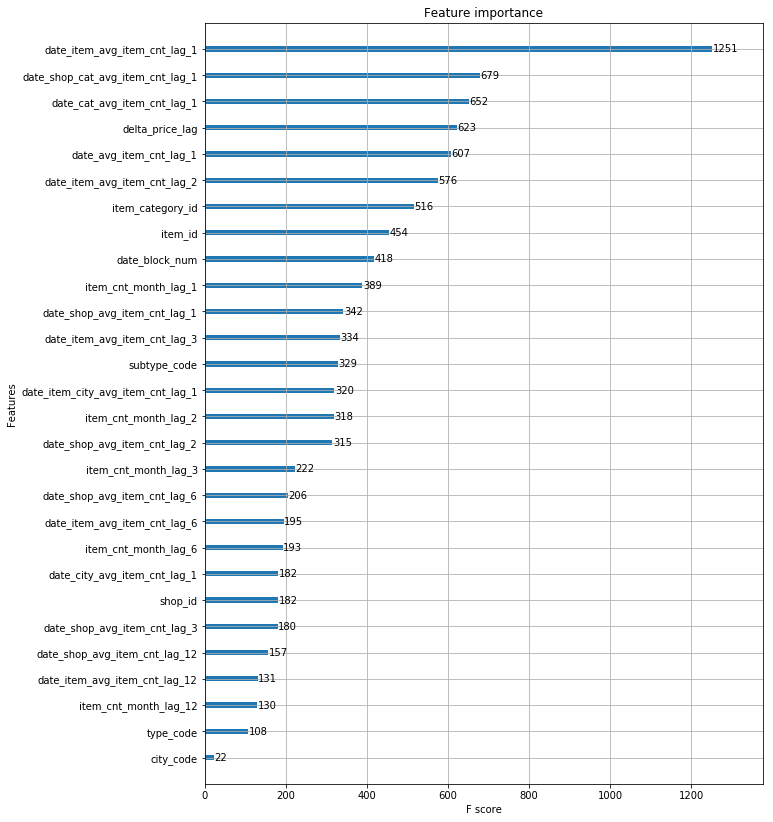

In [191]:
plot_features(model, (10,14))



In [194]:
model.predict(X_valid).shape, model.predict(X_valid).clip(0,20).shape

((238172,), (238172,))

In [193]:
test.head()

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34
